## Import bibliotek

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import numpy as np
import pandas as pd
import opendatasets as od
import chardet
import matplotlib.pyplot as plt

## Pobranie zbioru danych z kaggle

In [2]:
od.download('https://www.kaggle.com/datasets/jjayfabor/lettuce-growth-days')
#{"username":"jakubbg","key":"e42b293c818e4ecd7b9365ee037af428"}

Skipping, found downloaded files in ".\lettuce-growth-days" (use force=True to force download)


## Załadowanie zbioru danych

In [3]:
with open('./lettuce-growth-days/lettuce_dataset_updated.csv', 'rb') as f:
    result = chardet.detect(f.read())

In [4]:
dataset = pd.read_csv('./lettuce-growth-days/lettuce_dataset_updated.csv', encoding=result['encoding'])

In [5]:
print(len(dataset))
print(dataset[:5])

3169
   Plant_ID      Date  Temperature (°C)  Humidity (%)  TDS Value (ppm)  \
0         1  8/3/2023              33.4            53              582   
1         1  8/4/2023              33.5            53              451   
2         1  8/5/2023              33.4            59              678   
3         1  8/6/2023              33.4            68              420   
4         1  8/7/2023              33.4            74              637   

   pH Level  Growth Days  Temperature (F)  Humidity  
0       6.4            1            92.12      0.53  
1       6.1            2            92.30      0.53  
2       6.4            3            92.12      0.59  
3       6.4            4            92.12      0.68  
4       6.5            5            92.12      0.74  


## Wyciąganie ze zbioru wybranych kolumn

In [6]:
ph_level = dataset['pH Level'].values.tolist()
temp_F = dataset['Temperature (F)'].values.tolist()
humid = dataset['Humidity'].values.tolist()
days = dataset['Growth Days'].values.tolist()
plant_id = dataset['Plant_ID'].values.tolist()

## Przetwarzanie danych do postaci zbioru X i Y

Każda próbka składać się będzie ze średniej temperatury (F), średniej wilgotności oraz średniego ph gleby dla danej rośliny oraz z przypisanej jej klasy będącej ilością dni, jakie były wymagane do całkowitego wyrośnięcia rośliny.

In [7]:
X = []
Y = []

id = plant_id[0]
temp_sum = 0
humid_sum = 0
ph_level_sum = 0
day = 1

for i in range(0, len(plant_id)):
    if plant_id[i] == id:
        temp_sum += temp_F[i]
        humid_sum += humid[i]
        ph_level_sum += ph_level[i]
        day = days[i]
    else:
        temp = []
        temp.append(temp_sum/day)
        temp.append(humid_sum/day)
        temp.append(ph_level_sum/day)
        X.append(temp)
        Y.append(day)
        temp_sum = 0
        humid_sum = 0
        ph_level_sum = 0
        day = 1
        id = plant_id[i]

In [8]:
print(X[:10])

[[87.13199999999998, 0.6395555555555558, 6.382222222222223], [85.08488888888886, 0.6295555555555553, 6.311111111111113], [85.13148936170211, 0.6759574468085107, 6.27659574468085], [85.24333333333331, 0.6206250000000001, 6.293749999999999], [85.08488888888886, 0.6357777777777776, 6.264444444444444], [85.08488888888886, 0.6295555555555555, 6.297777777777776], [85.10851063829786, 0.625531914893617, 6.285106382978723], [85.08488888888886, 0.6457777777777778, 6.266666666666666], [85.15565217391303, 0.6530434782608696, 6.2195652173913025], [85.08488888888886, 0.6435555555555555, 6.262222222222222]]


## Normalizacja danych 

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X = np.array(X)
Y = np.array(Y)

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(Y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(41, 3) (28, 3) (41, 4) (28, 4)


C:\Users\obses\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Budowanie modelu sieci neuronowej

In [11]:
model = Sequential([
    Dense(8, activation='relu', input_dim=3, kernel_regularizer=regularizers.l2(0.04)),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.04)),
])

C:\Users\obses\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Trenowanie modelu

In [13]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), verbose=2)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Dokładność testowa: {test_accuracy:.2%}")

Epoch 1/500
2/2 - 1s - 265ms/step - accuracy: 0.3902 - loss: 2.1238 - val_accuracy: 0.1429 - val_loss: 2.1243
Epoch 2/500
2/2 - 0s - 20ms/step - accuracy: 0.2439 - loss: 2.1641 - val_accuracy: 0.2500 - val_loss: 2.1104
Epoch 3/500
2/2 - 0s - 20ms/step - accuracy: 0.3902 - loss: 2.1102 - val_accuracy: 0.5714 - val_loss: 2.0970
Epoch 4/500
2/2 - 0s - 23ms/step - accuracy: 0.4146 - loss: 2.0846 - val_accuracy: 0.7857 - val_loss: 2.0847
Epoch 5/500
2/2 - 0s - 21ms/step - accuracy: 0.5854 - loss: 2.1145 - val_accuracy: 0.8571 - val_loss: 2.0710
Epoch 6/500
2/2 - 0s - 20ms/step - accuracy: 0.6585 - loss: 2.0605 - val_accuracy: 0.8571 - val_loss: 2.0591
Epoch 7/500
2/2 - 0s - 21ms/step - accuracy: 0.6829 - loss: 2.0652 - val_accuracy: 0.8571 - val_loss: 2.0459
Epoch 8/500
2/2 - 0s - 23ms/step - accuracy: 0.6585 - loss: 2.0399 - val_accuracy: 0.8571 - val_loss: 2.0329
Epoch 9/500
2/2 - 0s - 22ms/step - accuracy: 0.8049 - loss: 2.0242 - val_accuracy: 0.8571 - val_loss: 2.0210
Epoch 10/500
2/2 -

## Efekty uczenia

Wytrenowany model osiąga skuteczność predykcji na poziomie 85,7%

In [14]:
model.evaluate(X_test, y_test)[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8571 - loss: 0.7300


0.8571428656578064

## Wykresy

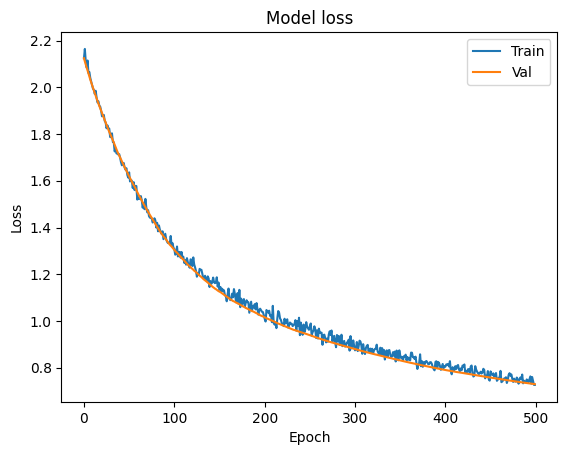

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

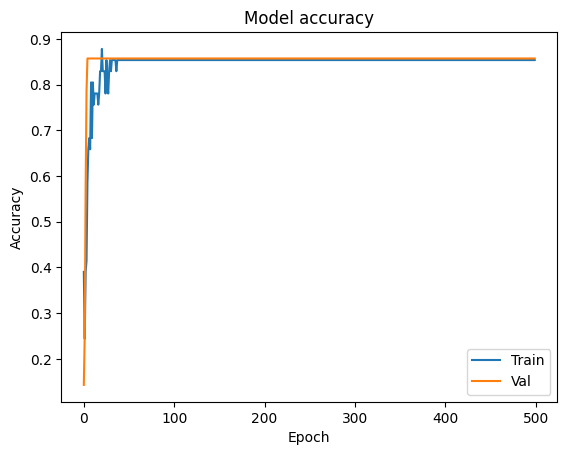

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## Zapisanie modelu do pliku

In [17]:
model.save('./model.keras') 